Machine learning model testing space


In [4]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from scipy.stats.mstats import winsorize
from scipy.stats import zscore, stats
from math import ceil

# ml modules
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import confusion_matrix

from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV

import statsmodels
import statsmodels.api as sm

from sklearn.svm import SVR
from sklearn.svm import SVC

from sklearn.decomposition import PCA

In [52]:
# read in 990 data that has been
# subsetted and cleaned in 990_cont_comp_EDA notebook
df = pd.read_csv('data/990_model_data.csv')

In [53]:
df.shape

(26881, 105)

In [9]:
df.head()

,ein,name_org,tax_date_begin,tax_date_end,tax_yr,phone,website,address,city,state,zip,org_form_corp,org_form_trust,org_form_association,org_form_other_form,formation_yr,state_legaldomicile,grp_return,exempt_status_501c3,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,name_contractor_1,address_contractor_1,city_contractor_1,state_contractor_1,zip_contractor_1,country_contractor_1,services_contractor_1,amt_paid_contractor_1,name_contractor_2,address_contractor_2,city_contractor_2,state_contractor_2,zip_contractor_2,country_contractor_2,services_contractor_2,amt_paid_contractor_2,name_contractor_3,address_contractor_3,city_contractor_3,state_contractor_3,zip_contractor_3,country_contractor_3,services_contractor_3,amt_paid_contractor_3,name_contractor_4,address_contractor_4,city_contractor_4,state_contractor_4,zip_contractor_4,country_contractor_4,services_contractor_4,amt_paid_contractor_4,name_contractor_5,address_contractor_5,city_contractor_5,state_contractor_5,zip_contractor_5,country_contractor_5,services_contractor_5,amt_paid_contractor_5,contractor_100k_ct,record_id,schema_version,irs_efile_id,random_string,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP
0,10056837,EASTERN MAINE ELECTRIC COOPERATIVE INC,2016-01-01,2016-12-31,2016,+1 (207) 454-7555,www.emec.com,PO Box 425,Calais,ME,046190425,True,False,False,False,1940.0,ME,no,NaN,12,15549792,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,Lucas Tree Experts,PO Box 958,Portland,ME,04104,NaN,Tree Clearing Work,144757.0,Preti Flaherty Beliveau Pachios LLP,PO Box 9546,Portland,ME,04112,NaN,Legal,284923.0,On Target Utility Services,617 Water St,Gardiner,ME,04345,NaN,Utility Construction,526681.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010056837_201612,2016v3.0,201722499349300607,NTk1ODY4MDk3ODk3NjYyMDY2OQ,0.081081,0.020501
1,10079380,CPORT CREDIT UNION,2016-01-01,2016-12-31,2016,+1 (207) 878-6200,WWW.CPORTCU.ORG,PO BOX 777,PORTLAND,ME,04104,True,False,False,False,1931.0,ME,no,NaN,14,9472036,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,SYNERGENT,2 LEDGEVIEW DRIVE,WESTBROOK,ME,04092,NaN,CORE PROCESSING AND RELATED SERVICES,806186.0,SYSTEMS ENGINEERING,120 EXCHANGE STREET,PORTLAND,ME,04101,NaN,INFORMATION TECH. SERVICES,171160.0,PM SYSTEMS (ACI WORLDWIDE CORP),99944 COLLECTION CENTER DR,CHICAGO,IL,60693,NaN,ONLINE BANKING PROVIDER,147655.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,010079380_201612,2016v3.0,201713179349301261,NTAxNDUzNjQ4MzgwNDIzMTg2MA,0.033708,0.045678
2,10114035,Maine Education Association,2015-09-01,2016-08-31,2016,+1 (207) 622-5866,www.maine.nea.org,35 Community Drive,Augusta,ME,04330,True,False,False,False,1859.0,ME,no,NaN,5,8503978,21,19,53,200.0,16110,0.0,676851.0,7646167.0,31555.0,0.0,8354573.0,152815.0,0

### Preliminary Feature Purging: remove features I have deemed to not contribute significant information to the models

In [63]:
# drop columns at beginning of dataset
# contact information for the org
# that I have determined aren't significant
df.drop(df.loc[:,'ein': 'zip'].columns, axis=1, inplace=True)

# drop columns at end of dataset
# that contain unique identifiers for tax return purposes
df.drop(df.loc[:,'record_id': 'random_string'].columns, axis=1, inplace=True)

In [60]:
# drop specific contractor info
# these will have a lot of nans for contractors 2, 3, 4, 5
# also the categories of services provided by 
# various vendors are very messy

df.drop(df.loc[:,'name_contractor_1': 'amt_paid_contractor_5'].columns, axis=1, inplace=True)

In [87]:
# one time adjustment
# df.exempt_status_501c3 = df.exempt_status_501c3.apply(lambda x: True if x == True else False)

## Create Target Features

#### 1. df['CON_CT_DIV_EMP_VOL_CT_flag']
Identify orgs with a high number of contractors and a low number of employees and volunteers

In [11]:
# find the 75th percentile
np.percentile(df['CON_CT_DIV_EMP_VOL_CT'], [75])

array([0.05627706])

In [12]:
# what percent of the total does the 75th quartile make up?
df[df['CON_CT_DIV_EMP_VOL_CT'] > np.percentile(df['CON_CT_DIV_EMP_VOL_CT'], [75])[0]].shape[0] / df.shape[0]

0.24999069975075333

In [54]:
# create flag column for orgs with 
# ratio above threshold
df['CON_CT_DIV_EMP_VOL_CT_flag'] = np.where(df['CON_CT_DIV_EMP_VOL_CT'] >= np.percentile(df['CON_CT_DIV_EMP_VOL_CT'],
                                                                               [75])[0], True, False)

In [55]:
# how many fall into each category?
df['CON_CT_DIV_EMP_VOL_CT_flag'].value_counts()

False    20160
True      6721
Name: CON_CT_DIV_EMP_VOL_CT_flag, dtype: int64

#### 2. df['CON_EXP_DIV_TOT_EXP_flag']
Identify orgs with contractor payments making up a high percentage of total expenses

In [15]:
# find the 75th percentile
np.percentile(df['CON_EXP_DIV_TOT_EXP'], [75])

array([0.07683324])

In [16]:
# what percent of the total does the 75th quartile make up?
df[df['CON_EXP_DIV_TOT_EXP'] > np.percentile(df['CON_EXP_DIV_TOT_EXP'], [75])[0]].shape[0] / df.shape[0]

0.24999069975075333

In [56]:
# create flag column for orgs with
# ratio above threshold
df['CON_EXP_DIV_TOT_EXP_flag'] = np.where(df['CON_EXP_DIV_TOT_EXP'] >= np.percentile(df['CON_EXP_DIV_TOT_EXP'],
                                                                               [75])[0], True, False)

In [57]:
# how many fall into each category?
df['CON_EXP_DIV_TOT_EXP_flag'].value_counts()

False    20160
True      6721
Name: CON_EXP_DIV_TOT_EXP_flag, dtype: int64

#### Flag Combinations, the intersection of 1 and 2 above will become the target feature I am trying to classify.

In [19]:
# how many orgs are flagged by both flags
df[(df.CON_CT_DIV_EMP_VOL_CT_flag == True) & \
(df.CON_EXP_DIV_TOT_EXP_flag == True)].shape

(2925, 92)

In [20]:
# what percent is that of the total?
df[(df.CON_CT_DIV_EMP_VOL_CT_flag == True) & \
(df.CON_EXP_DIV_TOT_EXP_flag == True)].shape[0] / \
df.shape[0]

0.10881291618615378

About 10%

In [58]:
df['TARGET_FEATURE'] = (df.CON_CT_DIV_EMP_VOL_CT_flag == True) & \
(df.CON_EXP_DIV_TOT_EXP_flag == True)

In [117]:
pd.options.display.max_rows = 999
df.head().dtypes

org_form_corp                              bool
org_form_trust                             bool
org_form_association                       bool
org_form_other_form                        bool
formation_yr                             object
state_legaldomicile                      object
grp_return                                 bool
exempt_status_501c3                        bool
exempt_status_501c_txt                    int64
gross_receipts                            int64
voting_memb_ct                            int64
voting_indepmemb_ct                       int64
employee_tot_ct                           int64
volunteer_tot_ct                        float64
income_tot_unrelated                      int64
income_net_unrelated                    float64
rev_giftsgrants_tot_prioryr             float64
rev_prgmservice_prioryr                 float64
rev_investmt_prioryr                    float64
rev_other_prioryr                       float64
rev_tot_prioryr                         

In [64]:
df.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,formation_yr,state_legaldomicile,grp_return,exempt_status_501c3,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,CON_CT_DIV_EMP_VOL_CT,CON_EXP_DIV_TOT_EXP,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP_flag,TARGET_FEATURE
0,True,False,False,False,1940.0,ME,False,NaN,12,15549792,11,11,37,0.0,0,0.0,0.0,15540869.0,280449.0,0.0,15821318.0,0.0,352726.0,1774024.0,0.0,0,13694568.0,15821318.0,0.0,39372255.0,26541056.0,12831199.0,0,15214173,335619,0,15549792,0,-242865,1753677,0,14038980,15549792,0,39367859,26785093,12582766,3.0,0.081081,0.020501,True,False,False
1,True,False,False,False,1931.0,ME,False,NaN,14,9472036,9,8,81,8.0,52565,-75519.0,0.0,8093378.0,128192.0,162461.0,8384031.0,0.0,850819.0,3076199.0,0.0,0,3456770.0,7383788.0,1000243.0,173898488.0,157544120.0,16354368.0,0,9089872,158726,223438,9472036,0,752626,3404135,0,4052976,8209737,1262299,188534687,170915216,17619471,3.0,0.033708,0.045678,False,False,False
2,True,False,False,False,1859.0,ME,False,NaN,5,8503978,21,19,53,200.0,16110,0.0,676851.0,7646167.0,31555.0,0.0,8354573.0,152815.0,0.0,6033969.0,0.0,0,2223320.0,8410104.0,-55531.0,3510564.0,820701.0,2689863.0,778662,7607073,45921,0,8431656,224247,0,6018982,0,2118455,8361684,69972,3640881,852359,2788522,3.0,0.011858,0.017884,False,False,False
3,True,False,False,False,1917.0,ME,False,True,3,57422298,8,7,442,15.0,0,0.0,450238.0,51510597.0,183397.0,8387.0,52152619.0,1000.0,0.0,22671669.0,0.0,0,26926818.0,49599487.0,2553132.0,57577945.0,13230564.0,44347381.0,327318,53676954,124583,19669,54148524,0,0,24500108,0,29557786,54057894,90630,56726534,12198910,44527624,8.0,0.017505,0.004949,False,False,False
4,True,False,False,False,1895.0,ME,False,NaN,7,5974176,12,12,139,50.0,2437,1437.0,0.0,3188739.0,608.0,263734.0,3453081.0,0.0,0.0,1381856.0,0.0,0,1726973.0,3108829.0,344252.0,9803605.0,3104088.0,6699517.0,0,3507190,1347,492375,4000912,0,0,1463461,0,1791727,3255188,745724,10535130,3089889,7445241,1.0,0.005291,0.039945,False,False,False


In [61]:
df.shape

(26881, 68)

## Correlation matrix to examine relationships between features and target variable

In [70]:
# how large is my dataset when I get dummies?
pd.get_dummies(df).shape

(26881, 358)

In [101]:
# identify features correlated with my target variable
pd.get_dummies(df).corr().loc[:,'TARGET_FEATURE'].sort_values(ascending=False).head(20)

TARGET_FEATURE                1.000000
CON_EXP_DIV_TOT_EXP_flag      0.605179
CON_CT_DIV_EMP_VOL_CT_flag    0.605179
CON_EXP_DIV_TOT_EXP           0.481229
formation_yr_2015.0           0.103418
formation_yr_2013.0           0.086091
formation_yr_2014.0           0.082622
formation_yr_2012.0           0.074163
formation_yr_2016.0           0.058149
state_legaldomicile_DE        0.049604
exempt_status_501c_txt        0.046729
formation_yr_2008.0           0.045944
formation_yr_2011.0           0.045373
state_legaldomicile_DC        0.044423
formation_yr_2010.0           0.044335
org_form_association          0.043454
formation_yr_2005.0           0.041867
formation_yr_2004.0           0.036628
formation_yr_2006.0           0.036350
formation_yr_2007.0           0.032761
Name: TARGET_FEATURE, dtype: float64

In [107]:
# identify the top 30 features most correlated with target feature
top_corr = list(pd.get_dummies(df).corr().loc[:,'TARGET_FEATURE'].sort_values(ascending=False).head(30).index)

In [110]:
pd.get_dummies(df)[top_corr]

,TARGET_FEATURE,CON_EXP_DIV_TOT_EXP_flag,CON_CT_DIV_EMP_VOL_CT_flag,CON_EXP_DIV_TOT_EXP,formation_yr_2015.0,formation_yr_2013.0,formation_yr_2014.0,formation_yr_2012.0,formation_yr_2016.0,state_legaldomicile_DE,exempt_status_501c_txt,formation_yr_2008.0,formation_yr_2011.0,state_legaldomicile_DC,formation_yr_2010.0,org_form_association,formation_yr_2005.0,formation_yr_2004.0,formation_yr_2006.0,formation_yr_2007.0,formation_yr_1994.0,formation_yr_2009.0,formation_yr_None,formation_yr_2001.0,formation_yr_1996.0,formation_yr_1995.0,state_legaldomicile_AL,formation_yr_2002.0,state_legaldomicile_VA,formation_yr_2000.0
0,False,False,True,0.020501,0,0,0,0,0,0,12,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,False,False,False,0.045678,0,0,0,0,0,0,14,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,False,False,False,0.017884,0,0,0,0,0,0,5,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,False,False,False,0.004949,0,0,0,0,0,0,3,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,False,False,False,0.039945,0,0,0,0,0,0,7,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26876,False,False,False,0.017948,0,0,0,0,0,0,3,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26877,False,False,True,0.024272,0,0,0,0,0,0,9,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26878,False,False,False,0.072639,0,0,0,0,0,0,4,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0
26879,True,True,True,0.087807,0,0,0,0,0,0,5,0,0,0,0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0


(30.0, 0.0)

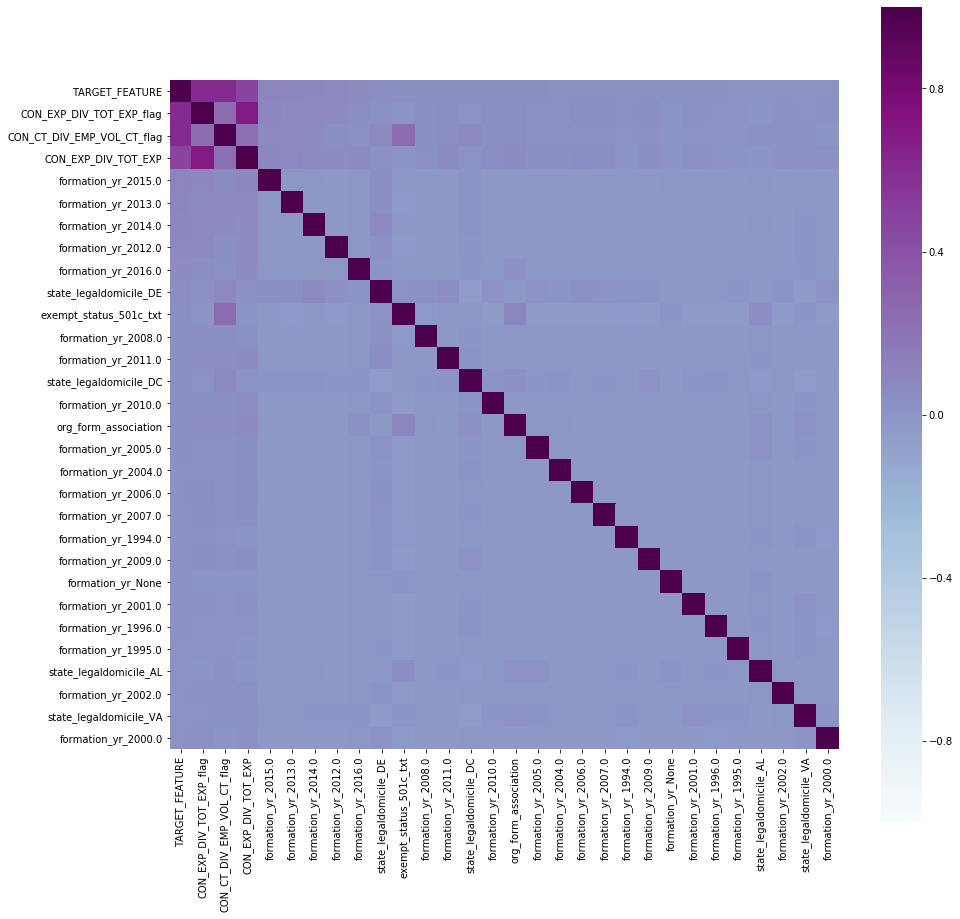

In [111]:
# compare features using a heatmap
# focusing only on features most correlated with 
# target variable
plt.figure(figsize=(15, 15))

ax = sns.heatmap(pd.get_dummies(df)[top_corr].corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=False, 
                 cmap='BuPu')

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

## Random forest to examine relationships between features and target variable

In [451]:
# cross_val_score(svc, X, y, cv=5)

In [524]:
# remove features that are composites of my target features
# X = X.drop(['employee_tot_ct', 
#              'volunteer_tot_ct'], axis=1)

In [118]:
# create features for classification
# while removing those I created in designing
# my target variable
X = pd.get_dummies(df).drop(['CON_CT_DIV_EMP_VOL_CT_flag', 
             'CON_EXP_DIV_TOT_EXP_flag',
            'CON_CT_DIV_EMP_VOL_CT',
            'CON_EXP_DIV_TOT_EXP',
            ], axis=1)

# create target for classification
y = df.TARGET_FEATURE

In [119]:
X.head()

,org_form_corp,org_form_trust,org_form_association,org_form_other_form,grp_return,exempt_status_501c3,exempt_status_501c_txt,gross_receipts,voting_memb_ct,voting_indepmemb_ct,employee_tot_ct,volunteer_tot_ct,income_tot_unrelated,income_net_unrelated,rev_giftsgrants_tot_prioryr,rev_prgmservice_prioryr,rev_investmt_prioryr,rev_other_prioryr,rev_tot_prioryr,grants_expense_tot_prioryr,benefits_expense_tot_prioryr,salaries_expense_tot_prioryr,fundraiseservfee_expense_tot_prioryr,fundraise_expense_tot_curyr,other_expense_tot_prioryr,expense_tot_prioryr,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_giftsgrants_tot_curyr,rev_prgmservice_curyr,rev_investmt_curyr,rev_other_curyr,rev_tot_curyr,grants_expense_tot_curyr,benefits_expense_tot_curyr,salaries_expense_tot_curyr,fundraiseservfee_expense_tot_curyr,other_expense_tot_curyr,expense_tot_curyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,TARGET_FEATURE,formation_yr_1096.0,formation_yr_1645.0,formation_yr_1650.0,formation_yr_1660.0,formation_yr_1689.0,formation_yr_1701.0,formation_yr_1709.0,formation_yr_1731.0,formation_yr_1740.0,formation_yr_1746.0,formation_yr_1749.0,formation_yr_1751.0,formation_yr_1754.0,formation_yr_1759.0,formation_yr_1763.0,formation_yr_1764.0,formation_yr_1765.0,formation_yr_1766.0,formation_yr_1769.0,formation_yr_1772.0,formation_yr_1774.0,formation_yr_1778.0,formation_yr_1780.0,formation_yr_1781.0,formation_yr_1782.0,formation_yr_1783.0,formation_yr_1784.0,formation_yr_1785.0,formation_yr_1787.0,formation_yr_1789.0,formation_yr_1791.0,formation_yr_1792.0,formation_yr_1793.0,formation_yr_1794.0,formation_yr_1795.0,formation_yr_1797.0,formation_yr_1798.0,formation_yr_1799.0,formation_yr_1800.0,formation_yr_1801.0,formation_yr_1802.0,formation_yr_1805.0,formation_yr_1806.0,formation_yr_1807.0,formation_yr_1808.0,formation_yr_1809.0,formation_yr_1810.0,formation_yr_1811.0,formation_yr_1812.0,formation_yr_1813.0,formation_yr_1814.0,formation_yr_1815.0,formation_yr_1816.0,formation_yr_1817.0,formation_yr_1818.0,formation_yr_1819.0,formation_yr_1820.0,formation_yr_1821.0,formation_yr_1823.0,formation_yr_1824.0,formation_yr_1825.0,formation_yr_1826.0,formation_yr_1827.0,formation_yr_1828.0,formation_yr_1829.0,formation_yr_1830.0,formation_yr_1831.0,formation_yr_1832.0,formation_yr_1833.0,formation_yr_1834.0,formation_yr_1835.0,formation_yr_1836.0,formation_yr_1837.0,formation_yr_1838.0,formation_yr_1839.0,formation_yr_1840.0,formation_yr_1841.0,formation_yr_1842.0,formation_yr_1843.0,formation_yr_1844.0,formation_yr_1845.0,formation_yr_1846.0,formation_yr_1847.0,formation_yr_1848.0,formation_yr_1849.0,formation_yr_1850.0,formation_yr_1851.0,formation_yr_1852.0,formation_yr_1853.0,formation_yr_1854.0,formation_yr_1855.0,formation_yr_1856.0,formation_yr_1857.0,formation_yr_1858.0,formation_yr_1859.0,formation_yr_1860.0,formation_yr_1861.0,formation_yr_1862.0,formation_yr_1863.0,formation_yr_1864.0,formation_yr_1865.0,formation_yr_1866.0,formation_yr_1867.0,formation_yr_1868.0,formation_yr_1869.0,formation_yr_1870.0,formation_yr_1871.0,formation_yr_1872.0,formation_yr_1873.0,formation_yr_1874.0,formation_yr_1875.0,formation_yr_1876.0,formation_yr_1877.0,formation_yr_1878.0,formation_yr_1879.0,formation_yr_1880.0,formation_yr_1881.0,formation_yr_1882.0,formation_yr_1883.0,formation_yr_1884.0,formation_yr_1885.0,formation_yr_1886.0,formation_yr_1887.0,formation_yr_1888.0,formation_yr_1889.0,formation_yr_1890.0,formation_yr_1891.0,formation_yr_1892.0,formation_yr_1893.0,formation_yr_1894.0,formation_yr_1895.0,formation_yr_1896.0,formation_yr_1897.0,formation_yr_1898.0,formation_yr_1899.0,formation_yr_1900.0,formation_yr_1901.0,formation_yr_1902.0,formation_yr_1903.0,formation_yr_1904.0,formation_yr_1905.0,formation_yr_1906.0,formation_yr_1907.0,formation_yr_1908.0,formation_yr_1909.0,formation_yr_1910.0,formation_yr_1911.0,formation_yr_1912.0,formation_yr_1913.0,formation_yr_1914.0,fo

### Random Forrest Classifier 


In [120]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4)

rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

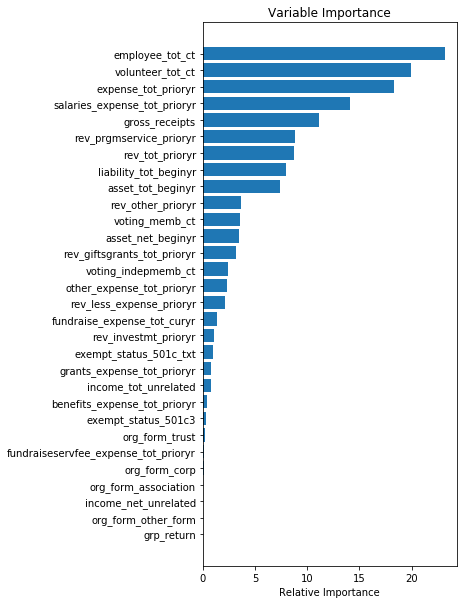

In [139]:
# visualize feature importances
plt.figure(figsize=(10, 10))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())[0:30]
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

### Secondary Feature Purging: after deeper feature investigation, remove features I have deemed to not contribute significant information to the models

#### Remove other features that aren't adding information to the model

In [325]:
# drop other misc columns
df.drop(['org_form_other_form_desc', 'grp_exempt_num', 'grp_return', 'grp_subs_all_incl', 'state_legaldomicile'], axis=1, inplace=True)

# drop other misc columns
# df.drop(['grp_return', 'grp_subs_all_incl'], axis=1, inplace=True)

In [327]:
# remove year since it didn't seem to add any additional information
# remove 'exempt_status.501c3' & 'exempt_status.501c_any' 
# since this information is being captured in exempt_status.501c_txt
df.drop(['formation_yr', 'exempt_status_501c3', 'exempt_status_501c_any'], axis=1, inplace=True)

In [336]:
# remove discontinue_dispose25 since it doesn't seem to contribute any information

df.drop(['discontinue_dispose25'], axis=1, inplace=True)

#### Consolidate Features
Examining the correlation heatmap, many of the financial amounts seem to be correlated with each other.  Using PCA, I will consolidate all the revenue features, as well as all of the expense features.

(13.0, 0.0)

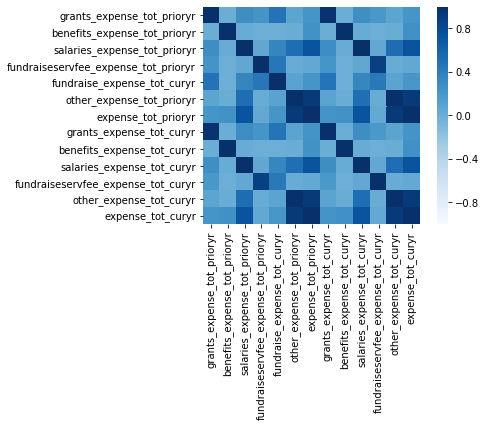

In [103]:
# plt.figure(figsize=(15, 15))

ax = sns.heatmap(df[['grants_expense_tot_prioryr',
 'benefits_expense_tot_prioryr',
 'salaries_expense_tot_prioryr',
 'fundraiseservfee_expense_tot_prioryr',
 'fundraise_expense_tot_curyr',
 'other_expense_tot_prioryr',
 'expense_tot_prioryr',
 'grants_expense_tot_curyr',
 'benefits_expense_tot_curyr',
 'salaries_expense_tot_curyr',
 'fundraiseservfee_expense_tot_curyr',
 'other_expense_tot_curyr',
 'expense_tot_curyr']].corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=False, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

(11.0, 0.0)

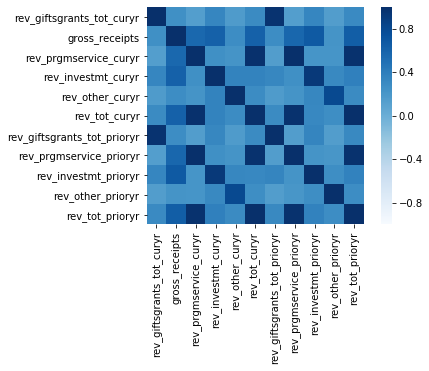

In [338]:
# plt.figure(figsize=(15, 15))

ax = sns.heatmap(df[['rev_giftsgrants_tot_curyr',
    'gross_receipts',
    'rev_prgmservice_curyr',
    'rev_investmt_curyr',
    'rev_other_curyr',
    'rev_tot_curyr',
    'rev_giftsgrants_tot_prioryr',
    'rev_prgmservice_prioryr',
    'rev_investmt_prioryr',
    'rev_other_prioryr',
    'rev_tot_prioryr']].corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=False, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [347]:
# consolidate rev features
pca = PCA(n_components=1)
df['rev_PCA'] = pca.fit_transform(df[['rev_giftsgrants_tot_curyr',
#     'gross_receipts',
    'rev_prgmservice_curyr',
    'rev_investmt_curyr',
    'rev_other_curyr',
    'rev_tot_curyr',
    'rev_giftsgrants_tot_prioryr',
    'rev_prgmservice_prioryr',
    'rev_investmt_prioryr',
    'rev_other_prioryr',
    'rev_tot_prioryr']])                                
                                     

print(pca.explained_variance_ratio_)

[0.97691019]


In [348]:
# remove rev features that have been consolidated
df.drop(df[['rev_giftsgrants_tot_curyr',
    'rev_prgmservice_curyr',
    'rev_investmt_curyr',
    'rev_other_curyr',
    'rev_tot_curyr',
    'rev_giftsgrants_tot_prioryr',
    'rev_prgmservice_prioryr',
    'rev_investmt_prioryr',
    'rev_other_prioryr',
    'rev_tot_prioryr']], axis=1, inplace=True)

In [349]:
# consolidate exp features
pca = PCA(n_components=1)
df['exp_PCA'] = pca.fit_transform(
         df[['grants_expense_tot_prioryr',
         'benefits_expense_tot_prioryr',
         'salaries_expense_tot_prioryr',
         'fundraiseservfee_expense_tot_prioryr',
         'fundraise_expense_tot_curyr',
         'other_expense_tot_prioryr',
         'expense_tot_prioryr',
         'grants_expense_tot_curyr',
         'benefits_expense_tot_curyr',
         'salaries_expense_tot_curyr',
         'fundraiseservfee_expense_tot_curyr',
         'other_expense_tot_curyr',
         'expense_tot_curyr']])                                
                                     

print(pca.explained_variance_ratio_)

[0.90936284]


In [350]:
# remove exp features that have been consolidated
df.drop(df[['grants_expense_tot_prioryr',
         'benefits_expense_tot_prioryr',
         'salaries_expense_tot_prioryr',
         'fundraiseservfee_expense_tot_prioryr',
         'fundraise_expense_tot_curyr',
         'other_expense_tot_prioryr',
         'expense_tot_prioryr',
         'grants_expense_tot_curyr',
         'benefits_expense_tot_curyr',
         'salaries_expense_tot_curyr',
         'fundraiseservfee_expense_tot_curyr',
         'other_expense_tot_curyr',
         'expense_tot_curyr']], axis=1, inplace=True)

In [539]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forrest Classifier 


In [536]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4)

rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [537]:
cross_val_score(rfc, X, y, cv=5)

array([0.89903846, 0.89829882, 0.89511654, 0.9045505 , 0.90066593])

Given that my target feature makes up about 10% of the dataset, these aren't impressive results.

In [540]:
predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.011097239561659037
Percent Type II errors: 0.08457021315947658

Test set accuracy:
Percent Type I errors: 0.009987053819123359
Percent Type II errors: 0.08914370260773072


In [541]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19037,240
Actual: Yes,1829,521


In [542]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4756,54
Actual: Yes,482,115


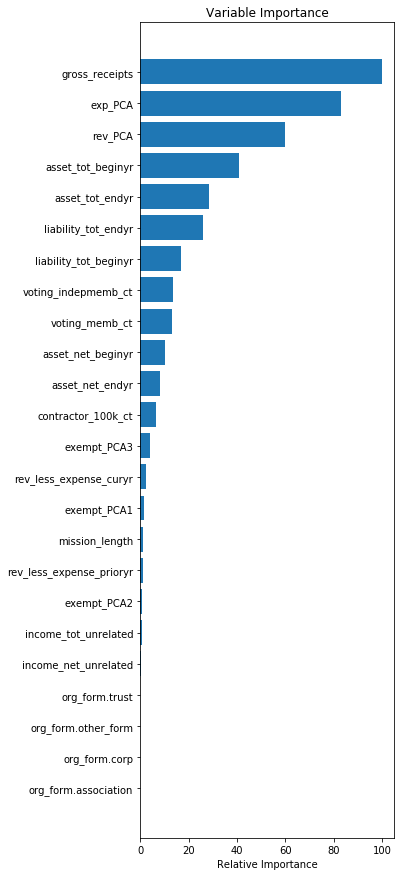

In [543]:
# visualize feature importances
plt.figure(figsize=(10, 15))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

### Support Vector Classifier

In [544]:
svc = SVC(gamma='auto')

svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

parameters to consider adjusting: (using grid search)
kernel
class weight
C

In [545]:
predict_train = svc.predict(X_train)
predict_test = svc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.11004253745145182


In [464]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19277,0
Actual: Yes,0,2350


Way overfitting on the training set

In [465]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4810,0
Actual: Yes,595,2


On training data this model almost exclusively predicted No.

feature importance not able to find for this model

### Gradient Boost Classifier

In [414]:
param_test = {'n_estimators':range(100, 501, 50),
              'learning_rate': [.01, 0.05],
              'max_depth': [2],
              'subsample': [.05, .1, .2]}

gsearch = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(
           max_features='sqrt',
           random_state=10), 
           param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presor

In [416]:
gsearch.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.2}

In [458]:
# using the best results from above
# run the model
params = {'n_estimators': 400,
          'max_depth': 2,
          'subsample': .2,
          'learning_rate': .05,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.015489896888149073
Percent Type II errors: 0.0299625468164794

Test set accuracy:
Percent Type I errors: 0.0160902533752543
Percent Type II errors: 0.03125577954503422


In [461]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,18942,335
Actual: Yes,648,1702


In [462]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4723,87
Actual: Yes,169,428


Gradient Boost Classifier did a much better job of predicting Yes

examine feature importances
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier.feature_importances_

## 2nd Iteration - Consolidate Features Farther


(27.0, 0.0)

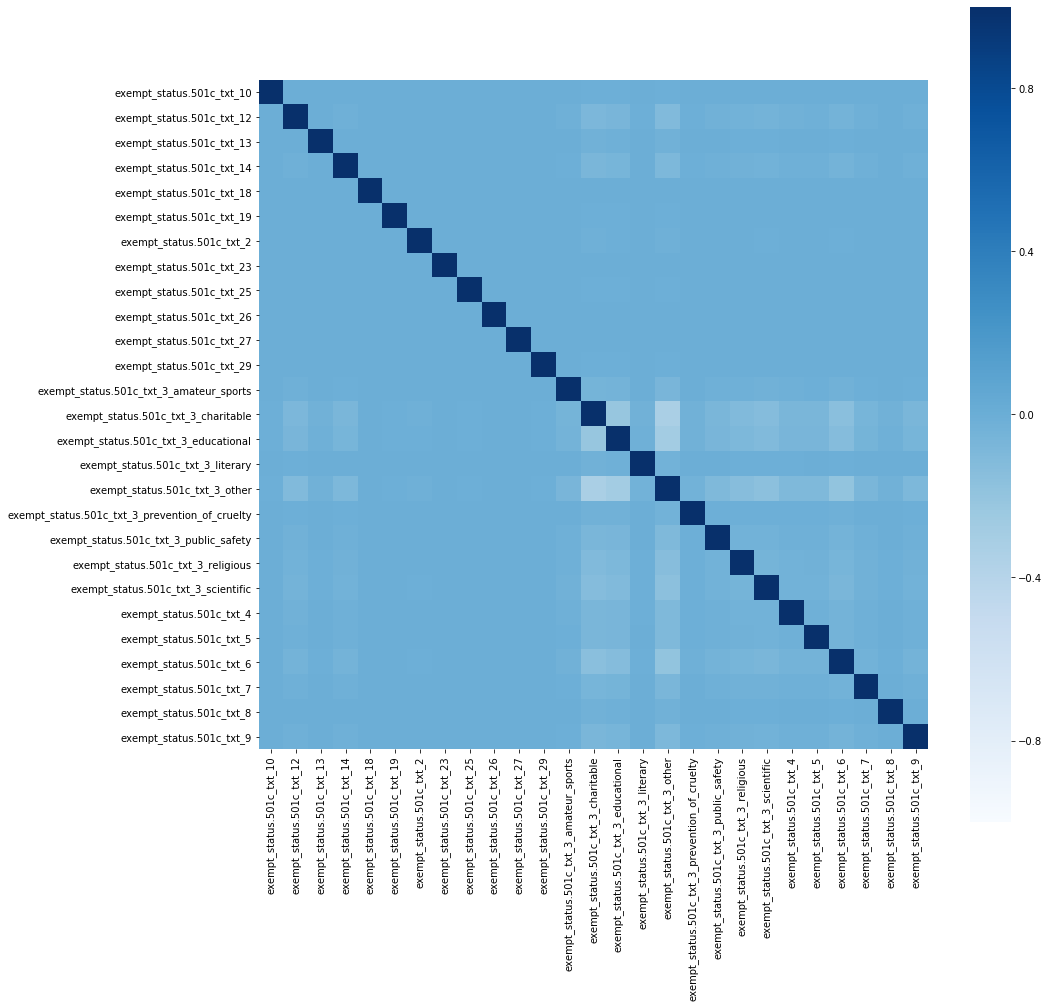

In [475]:
plt.figure(figsize=(15, 15))

ax = sns.heatmap(df[['exempt_status.501c_txt_10',
 'exempt_status.501c_txt_12',
 'exempt_status.501c_txt_13',
 'exempt_status.501c_txt_14',
 'exempt_status.501c_txt_18',
 'exempt_status.501c_txt_19',
 'exempt_status.501c_txt_2',
 'exempt_status.501c_txt_23',
 'exempt_status.501c_txt_25',
 'exempt_status.501c_txt_26',
 'exempt_status.501c_txt_27',
 'exempt_status.501c_txt_29',
 'exempt_status.501c_txt_3_amateur_sports',
 'exempt_status.501c_txt_3_charitable',
 'exempt_status.501c_txt_3_educational',
 'exempt_status.501c_txt_3_literary',
 'exempt_status.501c_txt_3_other',
 'exempt_status.501c_txt_3_prevention_of_cruelty',
 'exempt_status.501c_txt_3_public_safety',
 'exempt_status.501c_txt_3_religious',
 'exempt_status.501c_txt_3_scientific',
 'exempt_status.501c_txt_4',
 'exempt_status.501c_txt_5',
 'exempt_status.501c_txt_6',
 'exempt_status.501c_txt_7',
 'exempt_status.501c_txt_8',
 'exempt_status.501c_txt_9']].corr(), 
                 vmin=-1, vmax=1, center=0, 
                 square=True, 
                 annot=False, 
                 cmap="Blues")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

In [526]:
X2 = X.copy()

In [527]:
pca = PCA(n_components=3)

In [528]:
# consolidate exp features

p_components = pca.fit_transform(
         df[['exempt_status.501c_txt_10',
 'exempt_status.501c_txt_12',
 'exempt_status.501c_txt_13',
 'exempt_status.501c_txt_14',
 'exempt_status.501c_txt_18',
 'exempt_status.501c_txt_19',
 'exempt_status.501c_txt_2',
 'exempt_status.501c_txt_23',
 'exempt_status.501c_txt_25',
 'exempt_status.501c_txt_26',
 'exempt_status.501c_txt_27',
 'exempt_status.501c_txt_29',
 'exempt_status.501c_txt_3_amateur_sports',
 'exempt_status.501c_txt_3_charitable',
 'exempt_status.501c_txt_3_educational',
 'exempt_status.501c_txt_3_literary',
 'exempt_status.501c_txt_3_other',
 'exempt_status.501c_txt_3_prevention_of_cruelty',
 'exempt_status.501c_txt_3_public_safety',
 'exempt_status.501c_txt_3_religious',
 'exempt_status.501c_txt_3_scientific',
 'exempt_status.501c_txt_4',
 'exempt_status.501c_txt_5',
 'exempt_status.501c_txt_6',
 'exempt_status.501c_txt_7',
 'exempt_status.501c_txt_8',
 'exempt_status.501c_txt_9']])                                
                                     

print(pca.explained_variance_ratio_)

[0.30444441 0.21068515 0.12725713]


In [529]:
principalDf = pd.DataFrame(data = p_components
             , columns = ['exempt_PCA1', 'exempt_PCA2', 'exempt_PCA3'])

In [530]:
X2 = pd.concat([X2, principalDf], axis=1)

In [531]:
# remove exp features that have been consolidated
X2.drop(X2[['exempt_status.501c_txt_10',
 'exempt_status.501c_txt_12',
 'exempt_status.501c_txt_13',
 'exempt_status.501c_txt_14',
 'exempt_status.501c_txt_18',
 'exempt_status.501c_txt_19',
 'exempt_status.501c_txt_2',
 'exempt_status.501c_txt_23',
 'exempt_status.501c_txt_25',
 'exempt_status.501c_txt_26',
 'exempt_status.501c_txt_27',
 'exempt_status.501c_txt_29',
 'exempt_status.501c_txt_3_amateur_sports',
 'exempt_status.501c_txt_3_charitable',
 'exempt_status.501c_txt_3_educational',
 'exempt_status.501c_txt_3_literary',
 'exempt_status.501c_txt_3_other',
 'exempt_status.501c_txt_3_prevention_of_cruelty',
 'exempt_status.501c_txt_3_public_safety',
 'exempt_status.501c_txt_3_religious',
 'exempt_status.501c_txt_3_scientific',
 'exempt_status.501c_txt_4',
 'exempt_status.501c_txt_5',
 'exempt_status.501c_txt_6',
 'exempt_status.501c_txt_7',
 'exempt_status.501c_txt_8',
 'exempt_status.501c_txt_9']], axis=1, inplace=True)

In [532]:
X2.shape

(27034, 24)

In [533]:
X2.head()

,org_form.corp,org_form.trust,org_form.association,org_form.other_form,gross_receipts,voting_memb_ct,voting_indepmemb_ct,income_tot_unrelated,income_net_unrelated,rev_less_expense_prioryr,asset_tot_beginyr,liability_tot_beginyr,asset_net_beginyr,rev_less_expense_curyr,asset_tot_endyr,liability_tot_endyr,asset_net_endyr,contractor_100k_ct,mission_length,rev_PCA,exp_PCA,exempt_PCA1,exempt_PCA2,exempt_PCA3
0,True,False,False,False,15549792,11,11,0,0.0,0.0,39372255.0,26541056.0,12831199.0,0,39367859,26785093,12582766,3.0,177.991855,-9.168333e+07,-7.507422e+07,-0.129299,0.112403,0.240079
1,True,False,False,False,9472036,9,8,52565,-75519.0,1000243.0,173898488.0,157544120.0,16354368.0,1262299,188534687,170915216,17619471,3.0,177.991855,-1.051717e+08,-9.178369e+07,-0.126387,0.108608,0.225500
2,True,False,False,False,8503978,21,19,16110,0.0,-55531.0,3510564.0,820701.0,2689863.0,69972,3640881,852359,2788522,3.0,177.991855,-1.066637e+08,-9.176209e+07,-0.127715,0.110327,0.232003
3,True,False,False,False,57422298,8,7,0,0.0,2553132.0,57577945.0,13230564.0,44347381.0,90630,56726534,12198910,44527624,8.0,174.000000,-1.702434e+07,-1.703944e+07,-0.597764,-0.596733,-0.200318
4,True,False,False,False,5974176,12,12,2437,1437.0,344252.0,9803605.0,3104088.0,6699517.0,745724,10535130,3089889,7445241,1.0,177.991855,-1.156192e+08,-9.911281e+07,-0.123850,0.105373,0.213704


In [534]:
# create features for classification
# while removing those I created in designing
# my target variable
X = X2

# create target for classification
y = (df.CON_CT_DIV_EMP_VOL_CT_flag == True) & \
(df.CON_EXP_DIV_TOT_EXP_flag == True)

In [496]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Random Forrest Classifier 


In [497]:
rfc = ensemble.RandomForestClassifier(n_estimators=100, max_depth=4)

rfc.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [498]:
cross_val_score(rfc, X, y, cv=5)

array([0.94711538, 0.94101331, 0.93858676, 0.94358121, 0.93655198])

Given that my target feature makes up about 10% of the dataset, these aren't impressive results.

In [499]:
predict_train = rfc.predict(X_train)
predict_test = rfc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.006750820733342581
Percent Type II errors: 0.04892033106764692

Test set accuracy:
Percent Type I errors: 0.006658035879415572
Percent Type II errors: 0.04864065100795265


In [500]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19131,146
Actual: Yes,1058,1292


In [501]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4774,36
Actual: Yes,263,334


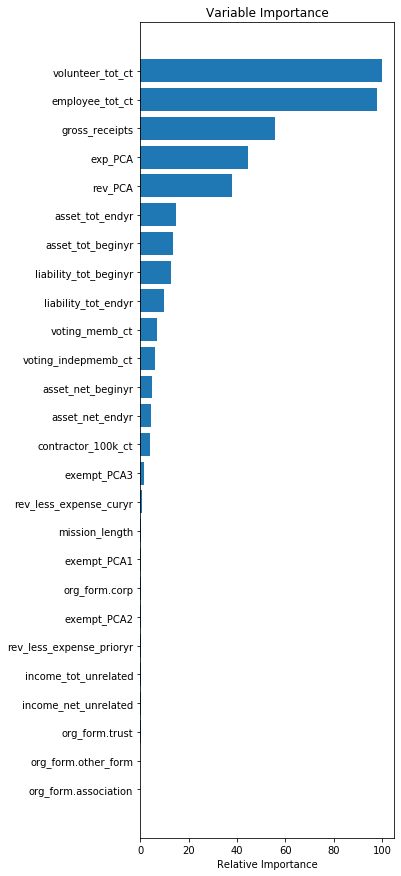

In [502]:
# visualize feature importances
plt.figure(figsize=(10, 15))

feature_importance = 100.0 * (rfc.feature_importances_ / rfc.feature_importances_.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance');

### Support Vector Classifier

In [503]:
svc = SVC(gamma='auto')

svc.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [504]:
predict_train = svc.predict(X_train)
predict_test = svc.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.0

Test set accuracy:
Percent Type I errors: 0.0
Percent Type II errors: 0.11004253745145182


Something clearly isn't right about this.

In [505]:
# training results
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,19277,0
Actual: Yes,0,2350


Something isn't right here, there is not way it should be this accurate.

In [506]:
# testing results
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4810,0
Actual: Yes,595,2


On training data this model almost exclusively predicted No.

### Gradient Boost Classifier

In [414]:
param_test = {'n_estimators':range(100, 501, 50),
              'learning_rate': [.01, 0.05],
              'max_depth': [2],
              'subsample': [.05, .1, .2]}

gsearch = GridSearchCV(estimator = ensemble.GradientBoostingClassifier(
           max_features='sqrt',
           random_state=10), 
           param_grid = param_test, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features='sqrt',
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presor

In [416]:
gsearch.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.2}

In [507]:
# using the best results from above
# run the model
params = {'n_estimators': 400,
          'max_depth': 2,
          'subsample': .2,
          'learning_rate': .05,
          'loss': 'deviance'}

# Initialize and fit the model.
clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predict_train = clf.predict(X_train)
predict_test = clf.predict(X_test)

# Accuracy tables
table_train = pd.crosstab(y_train, predict_train, margins=True)
table_test = pd.crosstab(y_test, predict_test, margins=True)

train_tI_errors = table_train.loc[0.0,1.0] / table_train.loc['All','All']
train_tII_errors = table_train.loc[1.0,0.0] / table_train.loc['All','All']

test_tI_errors = table_test.loc[0.0,1.0]/table_test.loc['All','All']
test_tII_errors = table_test.loc[1.0,0.0]/table_test.loc['All','All']

print((
    'Training set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}\n\n'
    'Test set accuracy:\n'
    'Percent Type I errors: {}\n'
    'Percent Type II errors: {}'
).format(train_tI_errors, train_tII_errors, test_tI_errors, test_tII_errors))

Training set accuracy:
Percent Type I errors: 0.01646090534979424
Percent Type II errors: 0.02945392333657003

Test set accuracy:
Percent Type I errors: 0.01719992602182356
Percent Type II errors: 0.029776216016275198


In [508]:
pd.DataFrame(data=confusion_matrix(y_train, predict_train)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,18921,356
Actual: Yes,637,1713


In [509]:
pd.DataFrame(data=confusion_matrix(y_test, predict_test)[:,:],    
              index= ['Actual: No', 'Actual: Yes'],
    columns= ['Predicted: No', 'Predicted: Yes'])

,Predicted: No,Predicted: Yes
Actual: No,4717,93
Actual: Yes,161,436


Gradient Boost Classifier did a much better job of predicting Yes

*****************************
### Spare Parts:

In [ ]:
# identify columns
for c in df.columns:
    if 'contractor_1' in c:
        print(c)       

### OLS Regression - start with this, simply try to predict the number of contractors a not-for-profit org will have

In [110]:
# create target feature
y = df.contractor_100k_ct

# create testing features
X = df.drop('contractor_100k_ct', axis=1)

In [30]:
# create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [32]:
predictions = lrm.predict(X)
errors = y - predictions

print("Mean of the errors is: {}".format(np.mean(errors)))

Mean of the errors is: 0.043938614475381436


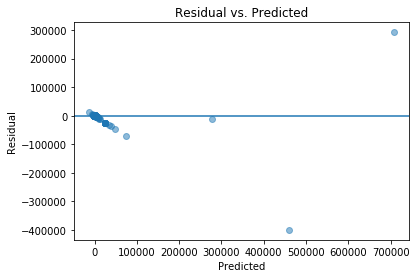

In [33]:
plt.scatter(predictions, errors, alpha=.5)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

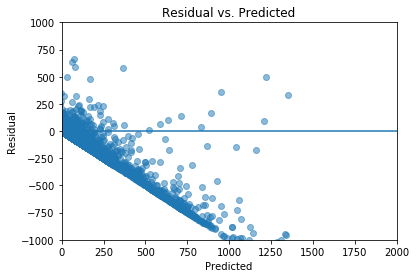

In [81]:
# examine a more zoomed up plot
plt.scatter(predictions, errors, alpha=.5)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')

plt.xlim(0, 2000)
plt.ylim(-1000, 1000)
plt.show()

In [34]:
# split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
lrm.fit(X_train, y_train) 

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [36]:
y_pred = lrm.predict(X_test)

In [37]:
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

-435.94480343204884

This seems to be wildly off, is this because of my outliers?

In [83]:
# I'm unsure why statsmodel is throwing this error
X2 = sm.add_constant(X)

results = sm.OLS(y, X2).fit()

results.summary()

C:\Users\mrkjh\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

### Random Forrest - regressor

In [38]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

regr.fit(X, y)
# cross_val_score(rfc, X, Y, cv=10)

C:\Users\mrkjh\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [39]:
cross_val_score(regr, X, y, cv=5)

array([-1.29600579e+02,  3.52264111e-02,  1.00216456e-01,  7.65246558e-02,
        1.26521655e-01])

results from this are terrible

In [40]:
f_importances = pd.DataFrame(regr.feature_importances_,
                            X.columns,
                            columns=['importance']).sort_values('importance', ascending=False)

In [41]:
f_importances.head(10)

,importance
con_ct_div_emp_ct,0.857230
expense_tot_curyr,0.069811
con_ct_div_exp,0.042767
formation_yr_1985.0,0.030189
rev_tot_curyr,0.000003
formation_yr_1966.0,0.000000
formation_yr_1973.0,0.000000
formation_yr_1972.0,0.000000
formation_yr_1971.0,0.000000
formation_yr_1970.0,0.000000


## Spare Parts - Categorization of 501c3s into one of the 7 subcategories

In [313]:
# read in org mission data

categories = pd.read_csv('data/501c3_categorized.csv')

In [385]:
# fill na for orgs that don't have a mission length
# since I only identified missions for 501c3 orgs
# all non-501c3 orgs will not have a mission length associated with them
df.mission_length.fillna(df.mission_length.mean(), inplace=True)

In [314]:
categories.head()

,ein,categories,mission_length
0,10130427,charitable,174
1,10177170,charitable,282
2,10179500,charitable,100
3,10196359,charitable,96
4,10198331,charitable,140


In [315]:
df = df.merge(categories, how='left', left_on='ein', right_on='ein')

In [316]:
# convert data type of exempt_status.501c_txt to object
# to be able to categorize this column
df['exempt_status.501c_txt'] = df['exempt_status.501c_txt'].apply(int).apply(str)

In [317]:
# concat categories onto 501c3 orgs
df.loc[df['exempt_status.501c_txt'] == '3', 'exempt_status.501c_txt'] = '3_' + df.categories


In [318]:
df.loc[df['exempt_status.501c_txt'].isna(), 'exempt_status.501c_txt'] = '3_other'

In [319]:
# examine distribution of categories
df['exempt_status.501c_txt'].value_counts(dropna=False)

3_other                    7948
3_charitable               5519
3_educational              4149
6                          2168
3_scientific               1569
3_religious                1111
12                          656
4                           625
3_public_safety             606
5                           579
9                           545
14                          513
7                           383
3_amateur_sports            286
3_prevention_of_cruelty      98
3_literary                   71
8                            59
13                           58
2                            29
25                           15
10                           14
19                           13
29                           11
27                            3
18                            2
23                            2
26                            2
Name: exempt_status.501c_txt, dtype: int64

In [320]:
# drop categories columns since it is no longer needed
df.drop(['categories'], axis=1, inplace=True)